In [1]:
%load_ext autoreload
import sys
sys.path.append("../..")

# Helium $f(z)$ Calculation

In [11]:
%autoreload


import matplotlib.pyplot as plt
%matplotlib inline


import matplotlib
matplotlib.rc_file('matplotlibrc')
matplotlib.rcParams['figure.figsize'] = [10,10]


# SET THIS TO TRUE TO USE LATEX
matplotlib.rcParams['text.usetex'] = True

from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

from tqdm import tqdm_notebook as tqdm

from astropy.io import fits


# np.set_printoptions(threshold=np.nan)

## Run DarkHistory

In [3]:
direc = '/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfs_20190120/'

highengphot_tf_interp = pickle.load(open(direc+"/processed/highengphot_tf_interp.raw", "rb"))
lowengphot_tf_interp  = pickle.load(open(direc+"/processed/lowengphot_tf_interp.raw", "rb"))
lowengelec_tf_interp  = pickle.load(open(direc+"/processed/lowengelec_tf_interp.raw", "rb"))
highengdep_interp     = pickle.load(open(direc+"/processed/highengdep_interp.raw", "rb"))
CMB_engloss_interp    = pickle.load(open(direc+"/processed/CMB_engloss_interp.raw", "rb"))

In [4]:
direc = "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/"
ics_thomson_ref_tf = pickle.load(open(direc+"ics_thomson_ref_tf.raw", "rb"))
ics_rel_ref_tf = pickle.load(open(direc+"ics_rel_ref_tf.raw", "rb"))
engloss_ref_tf = pickle.load(open(direc+"engloss_ref_tf.raw", "rb"))

In [25]:
#Annihilation or decay?
inj_type = 'decay'

#Annihilate/Decay into
inj_particle = 'electron'

#Useful definitions
if inj_particle == 'electron':
    inj_str = 'elec'
    mass = phys.me
else:
    inj_str = 'phot'
    mass = 0
    
CMB_subtracted = True

In [44]:
%autoreload
# import main

#injection energy, DM mass, center-of-mass energy
ind = 13

# log10eng0 = 3.6989700794219966
# log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(39)])

log10eng = np.log10(0.5e8)

tau=1.5e25
sigmav=0
end_rs = 4
start_rs = 3000

photeng = highengphot_tf_interp.eng
eleceng = lowengelec_tf_interp.eng

Einj = 10**log10eng
mDM = 2*Einj + 2*mass
print(np.log10(mDM))
Ecom=mDM

def rate_func_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)/Ecom
def rate_func_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)

if inj_type == 'swave':
    mDM = mDM/2
    Ecom = 2*mDM   

if inj_particle == 'electron':
    Etmp = eleceng[eleceng < Einj][-1]
    elec_spec_init = spectools.rebin_N_arr(
        np.array([2*Einj/Etmp]),
        np.array([Etmp]),
        eleceng
    )
    elec_spec_init.rs = start_rs
    elec_spec_init.switch_spec_type()

    phot_spec_init = Spectrum(photeng,
                             np.zeros_like(photeng),
                             spec_type='N',
                             rs=start_rs)
else:
    Etmp = photeng[photeng < Einj][-1]
    phot_spec_init = spectools.rebin_N_arr(
        np.array([2*Einj/Etmp]),
        np.array([Etmp]),
        photeng
    )
    phot_spec_init.rs = start_rs
    phot_spec_init.switch_spec_type()

    elec_spec_init = Spectrum(eleceng,
                             np.zeros_like(eleceng),
                             spec_type='N',
                             rs=start_rs)

f_DH_list = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp,
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=1, std_soln=True,
    reion_switch=False,
    struct_boost=None,
    ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
    user=None, verbose=False, 
    use_tqdm=True, helium_TLA=True
)

f_DH_list_with_br = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp,
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=1, std_soln=False,
    reion_switch=False,
    struct_boost=None,
    ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
    user=None, verbose=False, 
    use_tqdm=True, helium_TLA=True
)

8.004415953217887
0.9999999992990679 0.07885956786310544 0.704467733025


../../darkhistory/physics.py:334: RuntimeWarning: invalid value encountered in sqrt
  * (1 + T_in_K/T_1)**(1+p)
../../darkhistory/physics.py:334: RuntimeWarning: invalid value encountered in double_scalars
  * (1 + T_in_K/T_1)**(1+p)


-0.9867869294467058
-1.8026158738169973
-0.8497516123958022
-0.24157575192734665
-0.7007605814145417
-0.6195746717130677
-1.183539149998276
-0.5690978165289948
-0.17529128184948684
-0.6674746849557238
-0.885480611052657
-0.6147953745770914
-0.648102641854025
-0.8806958576836892
-0.5633011843217645
-0.6045003974442642
-0.667719588374514
-0.7250525851636345
-0.7860015745421551
-0.7276605139748972
-0.6266876584731622
-0.5315676342941804
-0.4416171456499594
-0.3592349634976571
-0.28209871277668924
-0.21359883766590065
-0.16381897695606312
-0.1012891649291624
-0.04045880181329842
0.9999999992990679 0.07885956786310544 0.704467733025


-0.23189870535382595
-0.07538745838759114
-1.1765241998628742
-1.3679634827752127
-0.9714468098720637
-0.9505493000975678
-1.2226223195994146
-0.8074853383485538
-0.9810160757234869
-0.577079697615777
-0.19369298525251039
-0.5683634705912111
-0.8656586454295956
-0.6011605133125508
-0.7227648397354527
-0.5883089006339377
-0.5666816639465191
-0.6586975193460991
-0.7338771710727041
-0.7963102747394575
-0.7177846437465896
-0.6176455826091611
-0.5231646414198581
-0.4338212254453882
-0.35174595112303214
-0.27488717947971153
-0.20753149550647765
-0.15762455521647034
-0.09531092082159492
-0.034930307060807686


[7, 3000, 1, 100000.0]

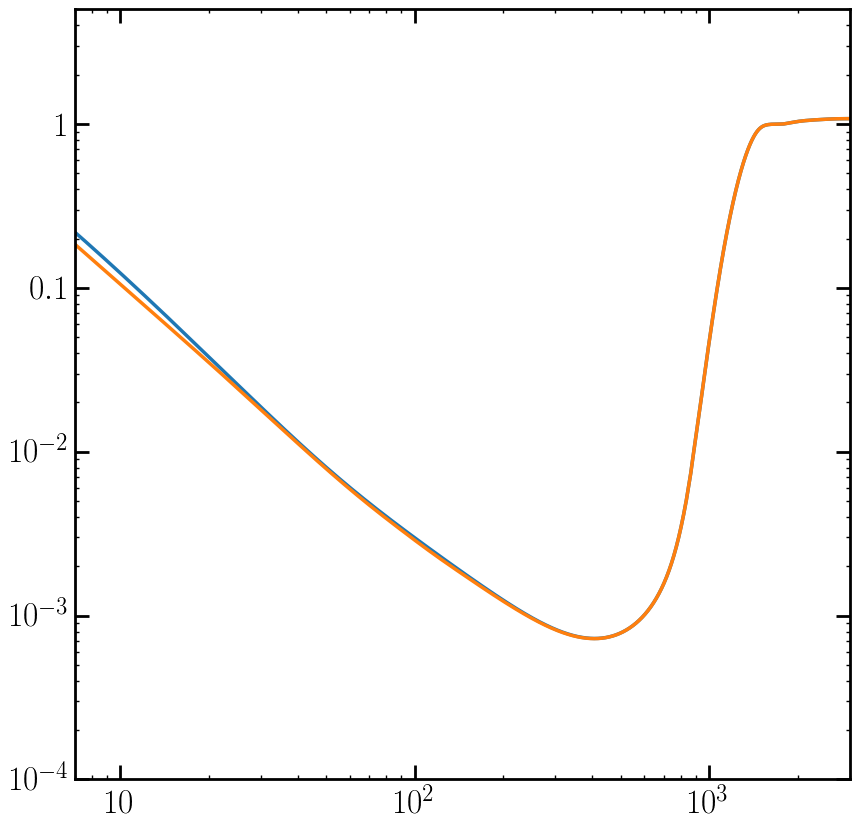

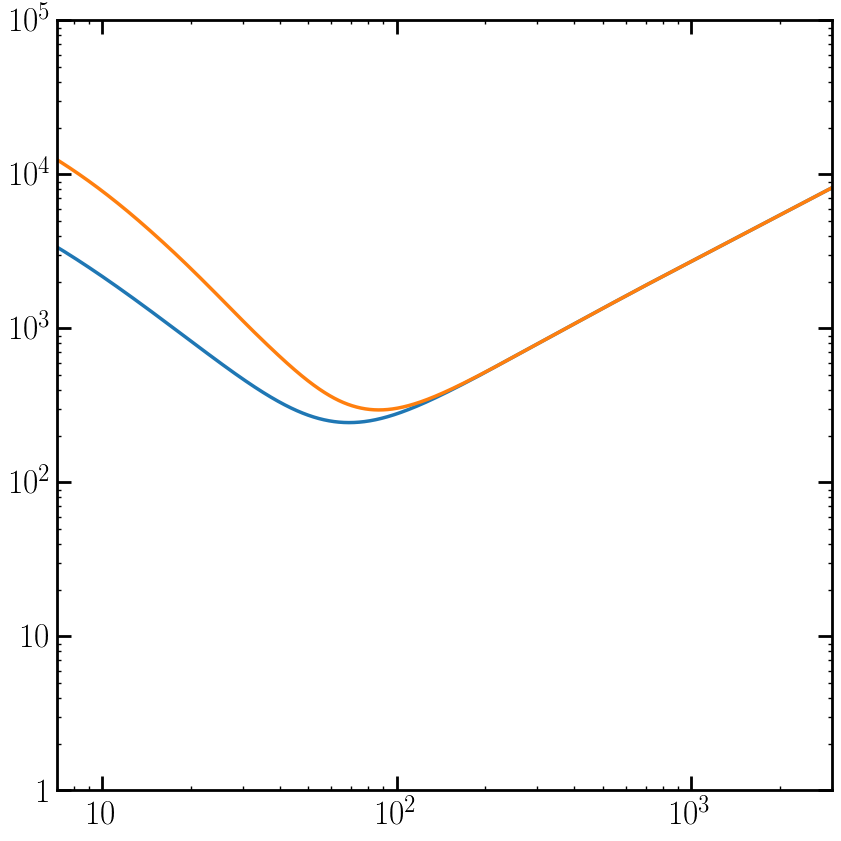

In [45]:
plt.figure()

plt.loglog()
plt.plot(
    f_DH_list[2].rs[1:], 
    f_DH_list[0][:,0]+f_DH_list[0][:,1]
)

plt.plot(
    f_DH_list_with_br[2].rs[1:],
    f_DH_list_with_br[0][:,0]+f_DH_list_with_br[0][:,1]
)

plt.axis([ 7, 3000, 1e-4, 5])

plt.figure()

plt.loglog()
plt.plot(
    f_DH_list[2].rs[1:], 
    f_DH_list[1]/phys.kB
)
plt.plot(
    f_DH_list_with_br[2].rs[1:],
    f_DH_list_with_br[1]/phys.kB
)

plt.axis([ 7, 3000, 1, 1e5])

In [ ]:
# class MacOSFile(object):

#     def __init__(self, f):
#         self.f = f

#     def __getattr__(self, item):
#         return getattr(self.f, item)

#     def read(self, n):
#         # print("reading total_bytes=%s" % n, flush=True)
#         if n >= (1 << 31):
#             buffer = bytearray(n)
#             idx = 0
#             while idx < n:
#                 batch_size = min(n - idx, 1 << 31 - 1)
#                 # print("reading bytes [%s,%s)..." % (idx, idx + batch_size), end="", flush=True)
#                 buffer[idx:idx + batch_size] = self.f.read(batch_size)
#                 # print("done.", flush=True)
#                 idx += batch_size
#             return buffer
#         return self.f.read(n)

#     def write(self, buffer):
#         n = len(buffer)
#         print("writing total_bytes=%s..." % n, flush=True)
#         idx = 0
#         while idx < n:
#             batch_size = min(n - idx, 1 << 31 - 1)
#             print("writing bytes [%s, %s)... " % (idx, idx + batch_size), end="", flush=True)
#             self.f.write(buffer[idx:idx + batch_size])
#             print("done.", flush=True)
#             idx += batch_size


# def pickle_dump(obj, file_path):
#     with open(file_path, "wb") as f:
#         return pickle.dump(obj, MacOSFile(f), protocol=pickle.HIGHEST_PROTOCOL)


# direc = '/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfs_20190120/'

# pickle_dump(highengphot_tf_interp, direc+"/processed/highengphot_tf_interp.raw")
# pickle_dump(lowengphot_tf_interp,  direc+"/processed/lowengphot_tf_interp.raw")
# pickle_dump(lowengelec_tf_interp,  direc+"/processed/lowengelec_tf_interp.raw")
# pickle.dump(highengdep_interp, open(direc+"/processed/highengdep_interp.raw", "wb"))
# pickle.dump(CMB_engloss_interp, open(direc+"/processed/CMB_engloss_interp.raw", "wb"))

In [ ]:
highengphot_tf_interp.x

In [35]:
f_DH_list_with_br[0][:,0]+f_DH_list_with_br[0][:,1]

array([1.07885957, 1.07885659, 1.0788535 , ..., 0.43971919, 0.4403822 ,
       0.44104611])